In [12]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [13]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [14]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [15]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [16]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [17]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [29]:
# Save references to each table
Stations = Base.classes.station

Measurement = Base.classes.measurement

In [30]:
# Create our session (link) from Python to the DB
from sqlalchemy.orm import Session
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [31]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()

print("Most recent date in the data set:", most_recent_date)

Most recent date in the data set: 2017-08-23


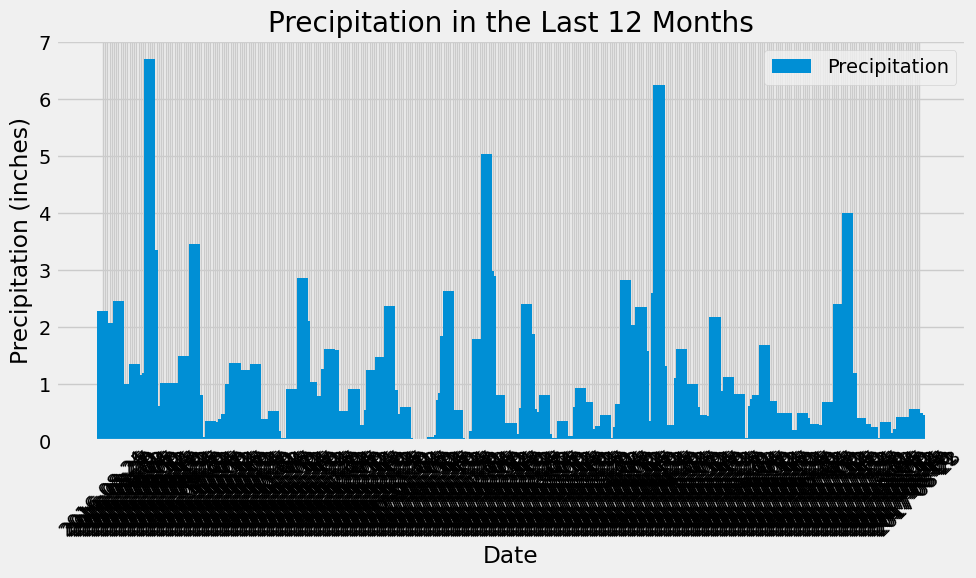

In [32]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year_ago = pd.to_datetime(most_recent_date) - pd.DateOffset(years=1)
one_year_ago = one_year_ago.to_pydatetime()

# Perform a query to retrieve the data and precipitation scores
query_result = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names

df = pd.DataFrame(query_result, columns=['Date', 'Precipitation'])
# Sort the dataframe by date

df.sort_values(by='Date', inplace=True)
# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))
plt.bar(df['Date'], df['Precipitation'], width=5, label='Precipitation')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.title('Precipitation in the Last 12 Months')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [33]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = df['Precipitation'].describe()
summary_stats

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64

# Exploratory Station Analysis

In [46]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Stations.id)).scalar()
total_stations

9

In [56]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations_query = session.query(Measurement.station, func.count(Measurement.station)).\
                            group_by(Measurement.station).\
                            order_by(func.count(Measurement.station).desc()).first()
print("Most active stations (descending order):")
for station, count in active_stations_query:
    print(f"Station: {station}, Count: {count}")

Most active stations (descending order):
Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [59]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations_query[0][0]

most_recent_date = session.query(func.max(Measurement.date)).filter(Measurement.station == most_active_station).scalar()
one_year_ago = pd.to_datetime(most_recent_date) - pd.DateOffset(years=1)

# Query to calculate the lowest, highest, and average temperature for the most active station
temperature_stats_query = session.query(func.min(Measurement.tobs),
                                       func.max(Measurement.tobs),
                                       func.avg(Measurement.tobs)).\
                            filter(Measurement.station == most_active_station).all()
lowest_temp, highest_temp, avg_temp = temperature_stats_query[0]

In [60]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

t_df = pd.DataFrame(temperature_stats_query, columns=['Date','Temperature'])
plt.figure(figsize=(8, 6))
plt.hist(t_df['Temperature'], bins=12, alpha=0.8, edgecolor='black')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.title(f'Temperature Observation Data for Station {most_active_station}\n(last 12 months)')
plt.tight_layout()
plt.show()

ValueError: 2 columns passed, passed data had 3 columns

# Close Session

In [16]:
# Close Session
session.close()